# 语音唤醒（用Spectrogram信号）

思路:在PART1和PART2的基础上将建立自定义的语音唤醒

数据集：http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

墙虽然挡住了google，但是可以直接下载这个数据集

In [14]:
import pandas as pd

import os
import pathlib
import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import librosa
import soundfile as sf

import sklearn as sk
import scipy
import scipy.io
from scipy.io import wavfile

import random
import pydub
from pydub import AudioSegment

### 音频文件采集
使用自制小工具：Customized_command_recorder.py
小工具除了录音功能以外，主要是为了方便将音频信号前后的静音信号滤除，避免音频裁剪的时候把音频信号裁掉。

采集声音“围棋”，建立文件夹“weiqi”放置在“speech_commands_v0.01”文件夹下

### 查看数据集

In [3]:
data_dir = pathlib.Path('speech_commands_v0.01')

In [4]:
[x for x in data_dir.iterdir() if x.is_dir()]

[WindowsPath('speech_commands_v0.01/bed'),
 WindowsPath('speech_commands_v0.01/bird'),
 WindowsPath('speech_commands_v0.01/cat'),
 WindowsPath('speech_commands_v0.01/dog'),
 WindowsPath('speech_commands_v0.01/down'),
 WindowsPath('speech_commands_v0.01/eight'),
 WindowsPath('speech_commands_v0.01/five'),
 WindowsPath('speech_commands_v0.01/four'),
 WindowsPath('speech_commands_v0.01/go'),
 WindowsPath('speech_commands_v0.01/happy'),
 WindowsPath('speech_commands_v0.01/house'),
 WindowsPath('speech_commands_v0.01/left'),
 WindowsPath('speech_commands_v0.01/marvin'),
 WindowsPath('speech_commands_v0.01/nine'),
 WindowsPath('speech_commands_v0.01/no'),
 WindowsPath('speech_commands_v0.01/off'),
 WindowsPath('speech_commands_v0.01/on'),
 WindowsPath('speech_commands_v0.01/one'),
 WindowsPath('speech_commands_v0.01/right'),
 WindowsPath('speech_commands_v0.01/seven'),
 WindowsPath('speech_commands_v0.01/sheila'),
 WindowsPath('speech_commands_v0.01/silence'),
 WindowsPath('speech_commands_v

In [5]:
from os import listdir
from os.path import isfile, join, isdir
onlydirs = [d for d in listdir(data_dir) if isdir(join(data_dir, d))]
onlydirs

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'silence',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'weiqi',
 'wow',
 'yes',
 'zero',
 '_background_noise_']

In [6]:
len(onlydirs)

33

### create silence audio
创建一个silence文件夹，并将_background_noise_文件夹中的背景噪声文件进行切割生成1秒的噪声文件

这一步在part2已经完成

### 扩展需要识别的唤醒词

将唤醒词与噪声数据进行混音以扩展测试集

In [54]:
weiqi_wav = [f for f in os.listdir(join(data_dir, 'weiqi')) if f.endswith('.wav')] 

In [55]:
weiqi_wav

['2021-02-21_113830_trim.wav',
 '2021-02-21_113830_trim_mid.wav',
 '2021-02-21_113830_vad_0.wav',
 '2021-02-21_113842_trim.wav',
 '2021-02-21_113842_trim_mid.wav',
 '2021-02-21_113842_vad_0.wav',
 '2021-02-21_114009.wav',
 '2021-02-21_114009_trim.wav',
 '2021-02-21_114009_trim_mid.wav',
 '2021-02-21_114139.wav',
 '2021-02-21_114139_trim.wav',
 '2021-02-21_114139_trim_mid.wav',
 '2021-02-21_114150_trim.wav',
 '2021-02-21_114150_trim_mid.wav',
 '2021-02-21_114150_vad_0.wav',
 '2021-02-21_114239_trim.wav',
 '2021-02-21_114239_trim_mid.wav',
 '2021-02-21_114239_vad_0.wav']

In [58]:
weiqi_audiosegment = []

for wav_name in weiqi_wav : 
    samples = AudioSegment.from_wav(join(join(data_dir,'weiqi'),wav_name))
    weiqi_audiosegment.append(samples) 

In [59]:
weiqi_audiosegment

In [51]:
background = [f for f in os.listdir(join(data_dir, '_background_noise_')) if f.endswith('.wav')] 

In [52]:
background

['doing_the_dishes.wav',
 'dude_miaowing.wav',
 'exercise_bike.wav',
 'pink_noise.wav',
 'running_tap.wav',
 'white_noise.wav']

In [53]:
background_noise = []

for wav_name in background : 
    samples = AudioSegment.from_wav(join(join(data_dir,'_background_noise_'),wav_name))
    background_noise.append(samples) 

In [22]:
background_noise

In [60]:
# Random pick start point
# len(Audiosegment) 单位是时长毫秒
# def get_one_noise(noise_num=0, duration=1000):
#     selected_noise = background_noise[noise_num]
#     start_idx = random.randint(0, len(selected_noise) - 1 - duration)
#     return selected_noise[start_idx:(start_idx + duration)]

In [83]:
# 将第一个围棋音频和第一个背景噪声进行混音并存储

# sound = weiqi_audiosegment[0]
# noise = get_one_noise(0, len(weiqi_audiosegment[0]))
# # 把noise的音量降为sound音量的一半
# noise = noise - ((1.5* abs(sound.dBFS))-abs(noise.dBFS))
# combined = sound.overlay(noise)
# combined.export(join(join(data_dir,'weiqi'),f'sound0_noise0_0.wav'), format="wav")

<_io.BufferedRandom name='speech_commands_v0.01\\weiqi\\sound0_noise0_0.wav'>

In [92]:
# 每个文件生成200个带噪声的样本

SAMPLE_NUM = 100

for weiqi_num,_ in enumerate(weiqi_audiosegment):
    for noise_num,_ in enumerate(background_noise):
        sound = weiqi_audiosegment[weiqi_num]
        for sn in range(SAMPLE_NUM):
            duration = len(weiqi_audiosegment[weiqi_num])
            selected_noise = background_noise[noise_num]
            start_idx = random.randint(0, len(selected_noise) - 1 - duration)
            noise = selected_noise[start_idx:(start_idx + duration)]
            # 把noise的音量降为sound音量的一半
            noise = noise - ((1.5* abs(sound.dBFS))-abs(noise.dBFS))
            combined = sound.overlay(noise)
            combined.export(join(join(data_dir,'weiqi'),f'sound{weiqi_num}_noise{noise_num}_{sn}.wav'), format="wav")
        
    


## Import the Speech Commands dataset

第1步：将所有的wav文件组成list

In [93]:
fileset = [file for file in glob.glob(str(data_dir) + "**/**/*.wav", recursive=True) if '_background_noise_' not in file]

In [94]:
len(fileset)

79535

第2步：list导入到DataFrame

In [95]:
dataset = pd.DataFrame(fileset, columns=['path'])

In [96]:
dataset.head()

,path
0,speech_commands_v0.01\bed\00176480_nohash_0.wav
1,speech_commands_v0.01\bed\004ae714_nohash_0.wav
2,speech_commands_v0.01\bed\004ae714_nohash_1.wav
3,speech_commands_v0.01\bed\00f0204f_nohash_0.wav
4,speech_commands_v0.01\bed\00f0204f_nohash_1.wav


第3步：将文件夹的名称提取作为指令

In [97]:
dataset['command'] = dataset['path'].apply(lambda x : os.path.basename(os.path.dirname(x)))

In [98]:
dataset.head()

,path,command
0,speech_commands_v0.01\bed\00176480_nohash_0.wav,bed
1,speech_commands_v0.01\bed\004ae714_nohash_0.wav,bed
2,speech_commands_v0.01\bed\004ae714_nohash_1.wav,bed
3,speech_commands_v0.01\bed\00f0204f_nohash_0.wav,bed
4,speech_commands_v0.01\bed\00f0204f_nohash_1.wav,bed


第4步：增加一列target_command，将不在target_command中的指令修改为unknown

['weiqi', 'unknown']

In [99]:
dataset['command'].unique()

array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'silence', 'six', 'stop',
       'three', 'tree', 'two', 'up', 'weiqi', 'wow', 'yes', 'zero'],
      dtype=object)

In [100]:
target = ['weiqi']

In [101]:
dataset['target_command'] = np.where(dataset['command'].isin(target), dataset['command'], 'unknown')

In [102]:
dataset.head()

,path,command,target_command
0,speech_commands_v0.01\bed\00176480_nohash_0.wav,bed,unknown
1,speech_commands_v0.01\bed\004ae714_nohash_0.wav,bed,unknown
2,speech_commands_v0.01\bed\004ae714_nohash_1.wav,bed,unknown
3,speech_commands_v0.01\bed\00f0204f_nohash_0.wav,bed,unknown
4,speech_commands_v0.01\bed\00f0204f_nohash_1.wav,bed,unknown


In [103]:
dataset['target_command'].unique()

array(['unknown', 'weiqi'], dtype=object)

第4步：提取spectrum并写入dataframe

In [104]:
# 计算时频谱

def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate /1e3))
    freqs, times, spec = scipy.signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [105]:
# 输入文件的路径返回spectrogram

def get_specgram(file_path):
    sample_rate, signal= scipy.io.wavfile.read(file_path)
    # 统一输入音频文件长度，当音频文件大于1秒时切尾，当音频长度小于1秒时补零
    signal_padding = np.zeros((16000,))
    if len(signal) >= 16000:
        signal_padding = signal[:16000]
    else:        
        signal_padding[:len(signal)] = signal
    # 获取频谱
    _, _, specgram = log_specgram(signal_padding, sample_rate=sample_rate)

    return specgram

In [106]:
from tqdm.auto import tqdm

tqdm.pandas(desc="my bar!")

# 获取每个文件的spectrogram
dataset['spec'] = dataset['path'].progress_apply(lambda x : get_specgram(x))

C:\Users\002706\Anaconda3\envs\tf\lib\site-packages\tqdm\std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


my bar!:   0%|          | 0/79535 [00:00<?, ?it/s]

In [117]:
# 用sklearn.preprocessing.LabelEncoder将指令转换为数字
le_all = sk.preprocessing.LabelEncoder()

# 增加新的一列all_cmd_value
dataset['all_cmd_value'] = le_all.fit_transform(dataset['command'])

In [108]:
dataset.head()

,path,command,target_command,spec,all_cmd_value
0,speech_commands_v0.01\bed\00176480_nohash_0.wav,bed,unknown,"[[-6.2836647, -4.6634054, -3.6306102, -3.62951...",0
1,speech_commands_v0.01\bed\004ae714_nohash_0.wav,bed,unknown,"[[5.674254, 5.0949345, -1.6267974, -2.909298, ...",0
2,speech_commands_v0.01\bed\004ae714_nohash_1.wav,bed,unknown,"[[4.890464, 4.2362165, -0.52367973, -4.504811,...",0
3,speech_commands_v0.01\bed\00f0204f_nohash_0.wav,bed,unknown,"[[0.2235076, -0.093135364, 1.7907851, 2.133407...",0
4,speech_commands_v0.01\bed\00f0204f_nohash_1.wav,bed,unknown,"[[-0.8384296, 0.48528323, 1.3839144, 0.5786768...",0


In [124]:
# 增加新的一列target_command的转换
le_target = sk.preprocessing.LabelEncoder()
dataset['target_cmd_value'] =  le_target.fit_transform(dataset['target_command'])

In [133]:
dataset['target_cmd_value_bool'] = dataset['target_command'].map({'unknown':0,'weiqi':1})

In [134]:
le_target.inverse_transform([0])

array(['unknown'], dtype=object)

In [135]:
le_all.classes_

array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'silence', 'six', 'stop',
       'three', 'tree', 'two', 'up', 'weiqi', 'wow', 'yes', 'zero'],
      dtype=object)

In [136]:
dataset.head()

,path,command,target_command,spec,all_cmd_value,target_cmd_value_bool,target_cmd_value
0,speech_commands_v0.01\bed\00176480_nohash_0.wav,bed,unknown,"[[-6.2836647, -4.6634054, -3.6306102, -3.62951...",0,0,0
1,speech_commands_v0.01\bed\004ae714_nohash_0.wav,bed,unknown,"[[5.674254, 5.0949345, -1.6267974, -2.909298, ...",0,0,0
2,speech_commands_v0.01\bed\004ae714_nohash_1.wav,bed,unknown,"[[4.890464, 4.2362165, -0.52367973, -4.504811,...",0,0,0
3,speech_commands_v0.01\bed\00f0204f_nohash_0.wav,bed,unknown,"[[0.2235076, -0.093135364, 1.7907851, 2.133407...",0,0,0
4,speech_commands_v0.01\bed\00f0204f_nohash_1.wav,bed,unknown,"[[-0.8384296, 0.48528323, 1.3839144, 0.5786768...",0,0,0


## Build and train the model

In [137]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, LSTM
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [176]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('best_model_part3_softmax.h5')

In [177]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23, 256)           412416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 256)           1024      
_________________________________________________________________
activation_1 (Activation)    (None, 23, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 128)           197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [178]:
loaded_model.pop()

In [179]:
loaded_model.trainable = False

In [180]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 23, 256)           412416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 256)           1024      
_________________________________________________________________
activation_1 (Activation)    (None, 23, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 23, 128)           197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [181]:
input_dim = (99, 161)

inputs = Input(shape=input_dim)
x = loaded_model(inputs, training=False)
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)


In [182]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 99, 161)]         0         
_________________________________________________________________
sequential (Sequential)      (None, 64)                750400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 750,465
Trainable params: 65
Non-trainable params: 750,400
_________________________________________________________________


In [183]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard

sgd = SGD(lr=0.00001, clipnorm=1.0)
adam = Adam(lr=1e-4, clipnorm=1.0)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=adam,
    metrics=['accuracy'],
)

In [165]:
X = np.array([i for i in dataset['spec']])

In [167]:
X.shape

(79535, 99, 161)

In [168]:
# 将目标指令转换为target_cmd_value
y = np.array(dataset['target_cmd_value'])

In [ ]:
y

In [169]:
y.shape

(79535,)

In [170]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
EPOCHS = 50
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(verbose=1, patience=3), 
               ModelCheckpoint('best_model_part3_sigmoid-retrain.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')],
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to best_model_part3_sigmoid-retrain.h5
995/995 [==============================] - 819s 823ms/step - loss: 0.6414 - accuracy: 1.0000 - val_loss: 0.6419 - val_accuracy: 1.0000
Epoch 2/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 1.00000
995/995 [==============================] - 816s 820ms/step - loss: 0.6414 - accuracy: 1.0000 - val_loss: 0.6419 - val_accuracy: 1.0000
Epoch 3/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00003: val_accuracy did not improve from 1.00000
995/995 [==============================] - 853s 857ms/step - loss: 0.6414 - accuracy: 1.0000 - val_loss: 0.6419 - val_accuracy: 1.0000
Epoch 4/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy:

Epoch 30/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 1.00000
995/995 [==============================] - 806s 810ms/step - loss: 0.6414 - accuracy: 1.0000 - val_loss: 0.6419 - val_accuracy: 1.0000
Epoch 31/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 1.00000
995/995 [==============================] - 801s 806ms/step - loss: 0.6414 - accuracy: 1.0000 - val_loss: 0.6419 - val_accuracy: 1.0000
Epoch 32/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 1.00000
995/995 [==============================] - 802s 806ms/step - loss: 0.6414 - accuracy: 1.0000 - val_loss: 0.6419 - val_accuracy: 1.0000
Epoch 33/50
995/995 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve 

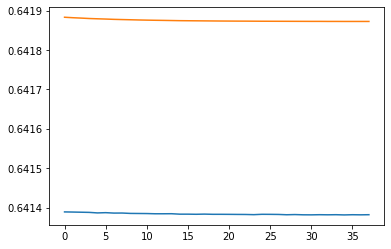

In [186]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.show()